# Adding DACCS in MESSAGE
In the previous tutorials, we have learnt how to create a baseline scenario (`westeros_baseline.ipynb`) and add emissions bounds (`westeros_emissions_bounds.ipynb`) to the baseline scenario. Here, we will show how to include an additional/new technology to a MESSAGE model. While the combination of currently existing technologies might be able to deliver the Paris targets, the deployment of some new technologies might improve the probability of meeting the targets and/or reducing the costs. These technologies include CO2 removal (CDR) technologies. Hence, in this tutorial, we will use direct air carbon capture and storage (DACCS) as an example of new technologies to be considered in climate mitigation pathways. 

In order to smoothly follow this tutorial, you have to alrady have the MESSAGEix framework installed and working. Moreover, you should have run the Westeros baseline and emissions bounds scenarios successfully as this tutorial is built on top of those scenarios.

If all set, we can start by importing all the packages we need and connect to a database that store the scenario input and results. We can also name the model as `Westeros Electrified` here.

In [45]:
import pandas as pd
import ixmp
import message_ix

from message_ix.utils import make_df

%matplotlib inline

mp = ixmp.Platform()

model = "Westeros Electrified"

After we are connected to the database, we can call the prevously run `"emission_bound"` scenario as our base model and clone the data before we start adding DACCS to the model. As prevoiusly mentioned, to run this tutorial, you have to have succesfully run the `"emission_bound"` scenario, which was built based on the `"baseline"` scenario.

In [46]:
base = message_ix.Scenario(mp, model=model, scenario="emission_bound")

scen = base.clone(
    model,
    "emission_bound_DACCS",
    "introducing an upper bound on emissions",
    keep_solution=False,)
scen.check_out()

year_df = scen.vintage_and_active_years()
vintage_years, act_years = year_df["year_vtg"], year_df["year_act"]
model_horizon = scen.set("year")
country = "Westeros"

Now, let's call the list of historical and model orizon years so we can use these lists for the next steps.

In [47]:
history = [690]
model_horizon = [700, 710, 720]

# Adding DACCS description
First step of adding DACCS as a technology in the model is by including DACCS into the `"technology"` set.

In [48]:
scen.add_set("technology", ["DACCS"])

Similar to what we did when generating the `"baseline"` scenario, the first thing we need to do is defining the input and output comodities of each technology. 

In [49]:
# Some common values to be used for both the "input" and "output" parameters
base = dict(
    node_loc=country,
    year_vtg=vintage_years,
    year_act=act_years,
    mode="standard",
    time="year",
    unit="-",
)

# Use the message_ix utility function make_df() to create a base data frame for
# different "input" parameter values
base_input = make_df("input", **base, node_origin=country, time_origin="year")

# Create a base data frame for different "output" parameter values
base_output = make_df("output", **base, node_dest=country, time_dest="year")

In this example, DACCS is described as a technology that consumes electricity in order to remove CO2 from the atmosphere. This electricity is assumed to be obtained from the grid. Hence, we define DACCS input as final energy in the form of electricity.

In [50]:
daccs_in = base_input.assign(
    technology="DACCS", commodity="electricity", level="final", value=1.0
)
scen.add_par("input", daccs_in)

Then, we can also add emissions and capacity factors as well as the technical lifetime of the technology. As can be seen in the code block below, the emissions factor has a negative value, showing that the technology removes insted of emits CO2.

In [51]:
emission_factor = make_df(
    "emission_factor",
    node_loc=country,
    year_vtg=vintage_years,
    year_act=act_years,
    mode="standard",
    unit="tCO2/kWa",
    technology="DACCS",
    emission="CO2",
    value=-20,
)
scen.add_par("emission_factor", emission_factor)

capacity_factor = make_df(
    "capacity_factor",
    node_loc=country,
    year_vtg=vintage_years,
    year_act=act_years,
    time="year",
    unit="-",
    technology='DACCS',
    value=1,
)
scen.add_par("capacity_factor", capacity_factor)
    
lifetime = make_df(
    "technical_lifetime",
    node_loc=country,
    year_vtg=model_horizon,
    unit="y",
    technology='DACCS',
    value=20,
)
scen.add_par("technical_lifetime", lifetime)

We also asume that DACCS is a first of a kind technology, i.e., the technology has never been historically deployed. Accordingly, to allow the technology to be installed in the system, we need to define initial deployment (`"initial_new_capacity_up"`) and capacity growth (`"growth_new_capacity_up"`) rates

In [52]:
initial_newcapacity_up = {
    "DACCS":0.5,
}

for tec,val in initial_newcapacity_up.items():
    df = make_df(
        "initial_new_capacity_up",
        node_loc=country,
        year_vtg=model_horizon,
        time="year",
        unit="GW",
        technology=tec,
        value=val,
    )
    scen.add_par("initial_new_capacity_up", df)

growth_newcapacity_up = {
    "DACCS":0.1,
}

for tec,val in growth_newcapacity_up.items():
    dfgrowth = make_df(
        "growth_new_capacity_up",
        node_loc=country,
        year_vtg=model_horizon,
        time="year",
        unit="-",
        technology=tec,
        value=val,
    )
    scen.add_par("growth_new_capacity_up", dfgrowth)

The last thing we need to do in describing DACCS is adding the technology costs data

In [53]:
# Add a new unit for ixmp to recognize as valid
mp.add_unit("USD/kW")

# in $ / kW (specific investment cost)
capex = make_df(
    "inv_cost",
    node_loc=country,
    year_vtg=model_horizon,
    unit="USD/kW",
    technology='DACCS',
    value=2800,
)
scen.add_par("inv_cost", capex)
    
# in $ / kW / year (every year a fixed quantity is destinated to cover part of the O&M costs
# based on the size of the plant, e.g. lightning, labor, scheduled maintenance, etc.)

omfix = make_df(
    "fix_cost",
    node_loc=country,
    year_vtg=vintage_years,
    year_act=act_years,
    unit="USD/kWa",
    technology='DACCS',
    value=30,
)
scen.add_par("fix_cost", omfix)

# In $ / kWa (costs associated to the degradation of equipment
# when the plant is functioning per unit of energy consumed
# kW·year = 8760 kWh in generating electricity. Therefore the costs represents USD per 8760 kWh
# of electricity consumed.

omvar = make_df(
    "var_cost",
    node_loc=country,
    year_vtg=vintage_years,
    year_act=act_years,
    mode="standard",
    time="year",
    unit="USD/kWa",
    technology='DACCS',
    value=5,
)
scen.add_par("var_cost", omvar)

# Solve Statement and Plotting Results
Finally, this is the solve statement and plotting results command

In [54]:
scen.commit(comment="Introducing emissions, DACCS technology, and setting an upper bound")
scen.set_as_default()

scen.solve()
scen.var("OBJ")["lvl"]

227281.53125

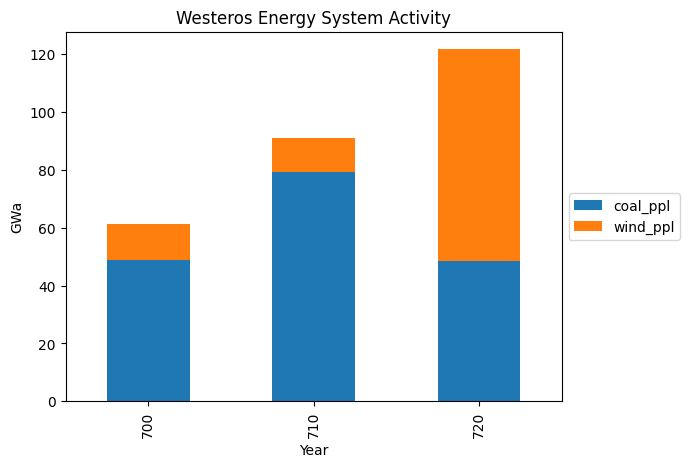

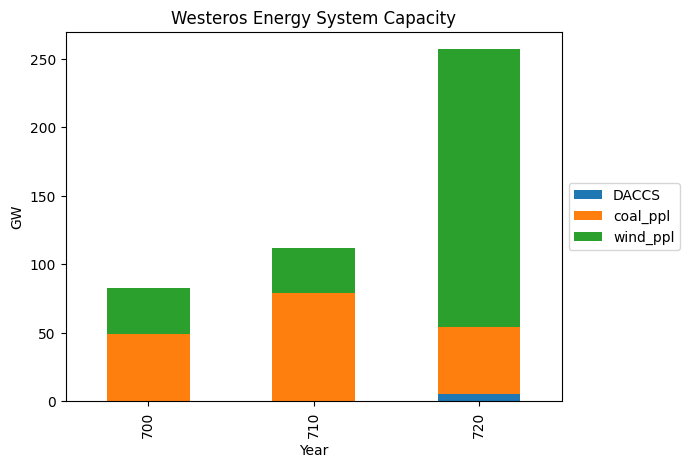

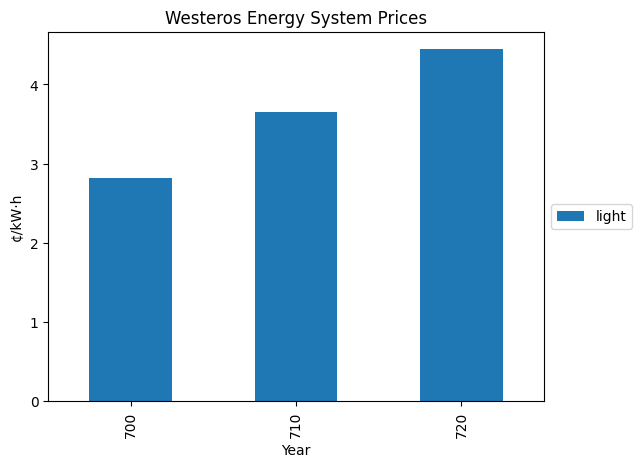

In [55]:
# Create a Reporter object to describe and carry out reporting
# calculations and operations (like plotting) based on `scenario`
# Add keys like "plot activity" to describe reporting operations.
# See tutorial/utils/plotting.py
from message_ix.reporting import Reporter
from message_ix.util.tutorial import prepare_plots

rep = Reporter.from_scenario(scen)

prepare_plots(rep)

# Only show a subset of technologies in the follow plots;
# e.g. exclude "bulb" and "grid"
rep.set_filters(t=["coal_ppl", "wind_ppl","DACCS"])

# Trigger the calculation and plotting
rep.get("plot activity")

# Create a different plot. The same filters are still active.
rep.get("plot capacity")

# Replace the technology filters with a commodity filter;
# show only "light" and not e.g. "electricity".
rep.set_filters(t=None, c=["light"])

# Create a price plot
rep.get("plot prices")

mp.close_db()

# All Done
Voila! You can now see DACCS included in the model. Congratulations!